In [300]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import pytz

import quandl

In [277]:
def port_eval(port):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    vol = np.log(port_ret).std()*np.sqrt(252)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    Max_Daily_Drawdown = Max_Daily_Drawdown.tail(1)
    
    neg_ret = port_ret[port_ret<1].dropna()
    sortino = np.log(neg_ret).std()*np.sqrt(252)
    
    cagr = port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1
    
    MAR = cagr/Max_Daily_Drawdown
    
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]), float(sortino.iloc[0]),
                                   float(Max_Daily_Drawdown.iloc[0])]},
                   index=['CAGR', 'Volatility', 'Sortino', 'Mad DD'])
    
    metrics = round(metrics*100, 2)
    metrics = metrics.astype(str) + '%'
    
    return metrics 

In [262]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

# Backtesting Portfolio

TODO:
- 

In [285]:
asset_1_tmp = yf.download("^GSPC")
#asset_2_tmp = yf.download("^VIX")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [301]:
asset_2_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")

In [311]:
asset_1 = asset_1_tmp['Close']
#asset_2 = asset_2_tmp["Close"]

In [312]:
asset_2 = asset_2_tmp["USD (AM)"]

In [313]:
assets = pd.concat([asset_1, asset_2], axis = 1)
assets.columns = ['Asset_1', 'Asset_2']
assets = assets.ffill()
assets = assets/assets.shift(1)
assets = assets.dropna()

In [338]:
initial = 1000
rebalance_freq = 5
port = []

w_1 = 0.7
w_2 = 1-w_1

asset_1 = initial * w_1
asset_2 = initial * w_2

port_w1=[]
port_w2=[]

for i in range(len(assets)):
    port.append(initial)
    port_w1.append(asset_1/initial)
    port_w2.append(asset_2/initial)
    
    asset_1 = asset_1 * assets['Asset_1'].iloc[i]
    asset_2 = asset_2 * assets['Asset_2'].iloc[i]
    initial = asset_1 + asset_2
    
    
    
    
    if i%rebalance_freq == 0: 
        asset_1 = initial * w_1
        asset_2 = initial * w_2

port = pd.DataFrame(port)
port.index = assets.index

In [339]:
port_ret = calc_port_ret(port)

,
CAGR,7.69%
Volatility,13.14%
Sortino,10.05%
Mad DD,-38.88%


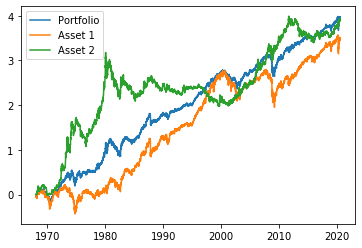

In [340]:
plt.plot(np.log(port_ret.cumprod()), label = "Portfolio");
plt.plot(np.log(assets['Asset_1'].cumprod()), label = "Asset 1");
plt.plot(np.log(assets['Asset_2'].cumprod()), label = "Asset 2");

plt.legend();

port_eval(port)

In [341]:
print("Asset 1: "+str(port_eval(assets['Asset_1'].cumprod())))
print("Asset 2: "+str(port_eval(assets['Asset_2'].cumprod())))

Asset 1:                    
CAGR          6.76%
Volatility   16.88%
Sortino      13.68%
Mad DD      -56.78%
Asset 2:                   
CAGR         7.62%
Volatility  19.62%
Sortino     15.06%
Mad DD      -70.0%
